<a href="https://colab.research.google.com/github/MarioBonse/Sketch-rnn/blob/master/train_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install --upgrade --quiet tensorflow-gpu
!pip install --upgrade --quiet PyDrive
!pip install -U tensorboardcolab
!pip install svgwrite

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


In [1]:
!git clone https://github.com/MarioBonse/Sketch-rnn.git
import os
os.chdir("Sketch-rnn")

Cloning into 'Sketch-rnn'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 189 (delta 2), reused 6 (delta 0), pack-reused 179
Receiving objects: 100% (189/189), 344.17 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [5]:
import data_Manager 
from HyperParameters import HP
import keras
import matplotlib.pyplot as plt
from train import *
import tensorflow as tf
from tensorboardcolab import *
#import draw

#tbc=TensorBoardColab()
HP.data_folder = "data/"
HP.data_name = "carrot.npz"
HP.data_location = "data/carrot.npz"
datas = data_Manager.Data()

# create the callback for data augmentaion during training
train_generator = data_Manager.DataGenerator(datas.train)
validation_encoder = datas.valid
validation_decoder = data_Manager.create_decoder_input(validation_encoder)
vaidation = [validation_encoder, validation_decoder]
HP.epochs = 20




remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 1), reused 5 (delta 1), pack-reused 2
Unpacking objects: 100% (8/8), done.
From https://github.com/MarioBonse/Sketch-rnn
   edc7b57..15889ec  master     -> origin/master
Updating edc7b57..15889ec
Fast-forward
 .gitignore      |   7 +------
 data/carrot.npz | Bin 0 -> 10052174 bytes
 data/cat.npz    | Bin 0 -> 14842947 bytes
 3 files changed, 1 insertion(+), 6 deletions(-)
 create mode 100644 data/carrot.npz
 create mode 100644 data/cat.npz


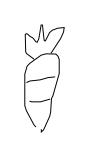

In [0]:
draw.draw_strokes(datas.train[0], svg_filename="carrot.svg")

In [6]:

"""
Create the model

1. ENCODER
"""
encoder_input = tf.keras.layers.Input(batch_shape = (HP.batch_size, None, HP.input_dimention), name = "encoder_input" )

encoderLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP.enc_hidden_size, return_sequences=False,
    recurrent_dropout=HP.rec_dropout, name = "LSTM_encoder"), merge_mode='concat', name = "BI_LSTM_encoder")(encoder_input)

hidden_state_mean = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "mean_MLP")(encoderLSTM)

variance_hat = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "variance_MLP")(encoderLSTM)

# from mean and variance to latent vairable z
z = tf.keras.layers.Lambda(sampling, output_shape=(HP.latent_dim,), name='z')([hidden_state_mean, variance_hat])

# create the model with keras
encoder = tf.keras.models.Model(encoder_input, [hidden_state_mean, variance_hat, z], name='encoder')
encoder.summary()
#tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

""" 
DECODER 
"""
# the decoder LSTM has an input composed by the sequence and also the hidden state
decoder_input_sequence = tf.keras.layers.Input(batch_shape = (HP.batch_size, HP.max_seq_length, HP.input_dimention), name = "decoder_seq_input" )
# we have also the latent variable as input of the LSTM with the sequence
inputLatentVariable = tf.keras.layers.RepeatVector(HP.max_seq_length)(z)
# so we concatentate the two vector
# as input we have the two vector above concatenated
totalInput = tf.keras.layers.Concatenate()([decoder_input_sequence, inputLatentVariable])
# Create LSTM for generation with input state = tanh(z)
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")
#
init_state = tf.keras.layers.Dense(units=(2*decoderLSTM.units), activation='tanh', name = "decoder_init_stat")(z)
h_0, c_0 = tf.split(init_state, num_or_size_splits=2, axis = 1)

# creation of the LSTM
decoder_output, _, _ = decoderLSTM(totalInput, initial_state = [h_0, c_0])

# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Build Keras model
seq_to_seq_VAE = tf.keras.models.Model([encoder_input, decoder_input_sequence], distribution_output)
seq_to_seq_VAE.summary()



W0827 01:10:47.664777 140392123692928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 01:10:47.673987 140392123692928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 01:10:47.675418 140392123692928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(100, None, 5)]     0                                            
__________________________________________________________________________________________________
BI_LSTM_encoder (Bidirectional) (100, 512)           536576      encoder_input[0][0]              
__________________________________________________________________________________________________
mean_MLP (Dense)                (100, 256)           131328      BI_LSTM_encoder[0][0]            
__________________________________________________________________________________________________
variance_MLP (Dense)            (100, 256)           131328      BI_LSTM_encoder[0][0]            
____________________________________________________________________________________________

Define the loss

In [0]:
    KL_weight = tf.keras.backend.variable(0.01, name = 'kl_weight')
    KL_wheight_schedule = data_Manager.changing_KL_wheight(KL_weight)
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # E[log P(X|z)]
        recon = reconstruction_loss(y_true, y_pred)
        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl = kl_loss(hidden_state_mean, variance_hat)

        return recon + kl*KL_weight

In [0]:
optimizer = tf.keras.optimizers.Adam(lr = HP.lr, clipvalue= HP.grad_clip)
seq_to_seq_VAE.compile(optimizer=optimizer,  loss = vae_loss)


In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
with tf.device('/device:GPU:0'):
  history = seq_to_seq_VAE.fit_generator(train_generator,
                       validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       steps_per_epoch=(datas.trainDimention)/HP.batch_size, 
                       epochs=HP.epochs, 
                       callbacks=[KL_wheight_schedule])
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_20_epochs.h5")

W0825 10:37:28.271658 140462281566080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
700/700 [==============================] - 901s 1s/step - loss: 0.8152 - val_loss: 0.6498
Epoch 2/20
700/700 [==============================] - 896s 1s/step - loss: 0.6140 - val_loss: 0.5962
Epoch 3/20
700/700 [==============================] - 896s 1s/step - loss: 0.5780 - val_loss: 0.5701
Epoch 4/20
700/700 [==============================] - 892s 1s/step - loss: 0.5584 - val_loss: 0.5552
Epoch 5/20
700/700 [==============================] - 894s 1s/step - loss: 0.5452 - val_loss: 0.5444
Epoch 6/20
700/700 [==============================] - 894s 1s/step - loss: 0.5355 - val_loss: 0.5357
Epoch 7/20
700/700 [==============================] - 895s 1s/step - loss: 0.5278 - val_loss: 0.5293
Epoch 8/20
700/700 [==============================] - 893s 1s/step - loss: 0.5214 - val_loss: 0.5236
Epoch 9/20
700/700 [==============================] - 894s 1s/step - loss: 0.5166 - val_loss: 0.5203
Epoch 10/20
700/700 [==============================] - 894s 1s/step - loss: 0.5121 - val_lo

Plot the history

dict_keys(['loss', 'val_loss'])


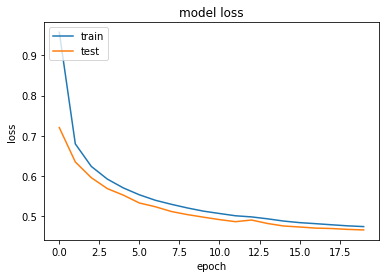

In [0]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
seq_to_seq_VAE.load_weights("model_weight_carrot_20_epochs.h5", by_name = True)


In [0]:
HP.epocs = 50
with tf.device('/device:GPU:0'):
  history = seq_to_seq_VAE.fit_generator(train_generator,
                       validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       steps_per_epoch=(datas.trainDimention)/HP.batch_size, 
                       epochs=50, 
                       callbacks=[KL_wheight_schedule], initial_epoch = 20)
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_50_epochs.h5")


W0826 16:55:22.563134 139747641997184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 21/50
700/700 [==============================] - 885s 1s/step - loss: 0.4881 - val_loss: 0.4952
Epoch 22/50
700/700 [==============================] - 883s 1s/step - loss: 0.4862 - val_loss: 0.4939
Epoch 23/50
700/700 [==============================] - 882s 1s/step - loss: 0.4849 - val_loss: 0.4934
Epoch 24/50
700/700 [==============================] - 883s 1s/step - loss: 0.4836 - val_loss: 0.4920
Epoch 25/50
700/700 [==============================] - 885s 1s/step - loss: 0.4824 - val_loss: 0.4916
Epoch 26/50
700/700 [==============================] - 882s 1s/step - loss: 0.4815 - val_loss: 0.4905
Epoch 27/50
700/700 [==============================] - 881s 1s/step - loss: 0.4804 - val_loss: 0.4895
Epoch 28/50
700/700 [==============================] - 883s 1s/step - loss: 0.4794 - val_loss: 0.4890
Epoch 29/50
700/700 [==============================] - 880s 1s/step - loss: 0.4787 - val_loss: 0.4888
Epoch 30/50
700/700 [==============================] - 882s 1s/step - loss: 0.4779

dict_keys(['loss', 'val_loss'])


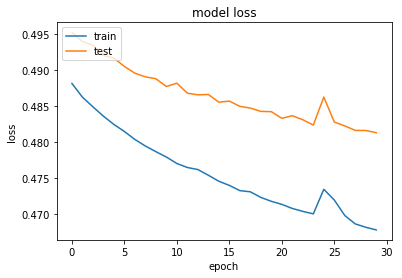

In [0]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()